# Extracting dispersion fromreciprocal space cuts.
#### Load the data

In [40]:
import sys,os,glob
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors,ticker,cm
%matplotlib inline
sys.path.append("/opt/mantidnightly/bin")
import scipy.signal as sp
import scipy.optimize as spo
from scipy.interpolate import interp1d
np.seterr("ignore")

GAMMA = chr(915)
workdir = 'C:/Users/Will/OneDrive/Documents/YZGO/CNCS_YZGO_analysis/individual_cuts_for_spinw/'
segment_labels_array = [['','M',GAMMA,'M','K',GAMMA],['',GAMMA,'K','M','K',GAMMA],['',GAMMA,'M','K',GAMMA,'M','K'],['','M',GAMMA,'M',GAMMA,'M'],[GAMMA,'M',GAMMA,'M','K',GAMMA],[GAMMA,'K','M',GAMMA,'']]


file_name_1 = 'GMG_4T0p3_Thickness,step0p1_ebin0p1-8T.txt'
file_name_2 = 'GKMKG_4T0p3_Thickness,step0p1_ebin0p1-8T.txt'

def get_line_from_coordinate_pair(a,b):
    x1 = a[0]
    x2 = b[0]
    y1 = a[1]
    y2 = b[1]
    if x1-x2 == 0: # CONSTANT H
        h_or_k = 'k'
        m = None
        c = x1
    elif y1-y2 == 0: # CONSTANT K
        h_or_k = 'h'
        m = 0
        c = y1
    else:
        h_or_k = 'h' # Default seems to be H
        m = (y2-y1)/(x2-x1)
        c = y1 - x1*m
    if m == None:
        return h_or_k,m,round(c,3)
    else:
        return h_or_k,round(m,3),round(c,3)

def calculate_other_variable(array,m,c):
    array = np.array(array)
    if m != None: # means we are calculating K
        calculated_array = array*m+c
    elif m == None: # means we are calculating H
        calculated_array = np.zeros(np.shape(array))
        calculated_array = calculated_array+c
    return calculated_array

def lexsort_by_row(array,row_1,row_2):
    indices = np.lexsort((array[row_2],array[row_1]))
    for i in range(len(array)):
        array[i] = array[i][indices]
    return array

#LOAD THE SINGULAR DATA FILE

def load_a_file(file,cut_direction,c):
    x = cut_direction[0]
    y = cut_direction[1]
    data=np.transpose(np.loadtxt(file))
    data[1] = np.around(data[1],decimals = 7)
    H = data[0]*x+c[0]
    K = data[0]*y+c[1]
    data[0] = H
    data = np.insert(data,1,K,axis=0)
    data = lexsort_by_row(data,0,1)
    data = np.ma.array(data,mask = np.isnan(data))
    return data
#Right now X is [H,-H,0] while the integration is centered on the line [H,H] = [0.5,0.5]
#So H,K given by data[0][i]+0.5,-data[0][i]+0.5

# Since Horace only outputs the array with one Q (H by default, unless constant in which case K)
# We have to calculate and insert the other Q for the sake of SpinW where the desired format is:
#QH        QK        QL    ENlim1    ENlim2        I1       EN1    sigma1        I2       EN2    sigma2

cut_direction = [1,-1,0]
orthog = [0.5,0.5,0]
data4TGMG = load_a_file(workdir+file_name_1,cut_direction,orthog)
cut_direction = [0.66667,-0.33333,0]
orthog = [0,0.5,0]
data4TGKMKG = load_a_file(workdir+file_name_2,cut_direction,orthog)
#smoothed stuff

#### Define function for yielding dispersion from a segment

In [43]:
#mode will be peak fit versus maximum value
from functools import reduce

def _1Lorentzian(x, amp1, cen1, wid1, bg):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2))+bg
    
def _2Lorentzian(x, amp1, cen1, wid1, amp2,cen2,wid2,bg):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2))+bg  +\
    (amp2*wid2**2/((x-cen2)**2+wid2**2))+bg

def line_prepender(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)
        
def get_dispersion_from_segment(array,min_energy = 0.5,max_energy = 2.45, mode = 0):
    #determine if h or k:
    h_or_k = 0
    if array[0][0]-array[0][1] == 0:
        h_or_k = 1
    else:
        h_or_k = 0
    indices = np.unique(array[h_or_k],return_index=True)[1]
    Qs = [array[h_or_k][index] for index in sorted(indices)]
    indices = np.unique(array[0],return_index=True)[1]
    H = [array[0][index] for index in sorted(indices)]
    indices = np.unique(array[1],return_index=True)[1]
    K = [array[1][index] for index in sorted(indices)]
    
    L = np.zeros([1,len(Qs)])
    if len(H) == 1:
        H = np.zeros(len(Qs))+array[0][0]
    if len(K) == 1:
        K = np.zeros(len(Qs))+array[0][1]
        
    if H[0] != array[0][0]:
        H = np.flip(H,0)
        print('Hflip')
    if K[0] != array[1][0]:
        print('Kflip')
        K = np.flip(K,0)
    Es = np.unique(array[2])
    
    #QH        QK        QL    ENlim1    ENlim2        I1       EN1    sigma1        I2       EN2    sigma2
    dispersion_array = np.empty([11,len(Qs)])
    dispersion_array[0] = H
    dispersion_array[1] = K
    dispersion_array[2] = L
    dispersion_array[3] = np.zeros(len(Qs))+min_energy + 0.0266405 #Here accounting for the offset at CNCS
    dispersion_array[4] = np.zeros(len(Qs))+max_energy + 0.0266405
    
    # Now need to determine the energy at which we find the maximum intensity for each Q
    if mode == 0:
        for i in range(len(Qs)):
            #Recall segments are 0/1/2/3/4 <-> Qx/Qy/E/Int/Error
            # Get the set of constant Q
            indices_Qs = np.where(array[h_or_k] == Qs[i]) 
            indices_Emin = np.where(array[2] > min_energy)
            indices_Emax = np.where(array[2] < max_energy)
            indices = reduce(np.intersect1d, (indices_Qs, indices_Emin, indices_Emax))
            #Find the maximum intensity
            dispersion_array[5][i] = array[3][indices].max()/array[3][indices].max()
            #get the index of this to find the corresponding energy, sigma
            max_intensity_index = np.where(array[3] == array[3][indices].max())
            dispersion_array[6][i] = array[2][max_intensity_index[0].max()]+0.0266405
            dispersion_array[7][i] = array[4][max_intensity_index[0].max()]*500
            dispersion_array[8][i] = dispersion_array[5][i]
            dispersion_array[9][i] = dispersion_array[6][i]
            dispersion_array[10][i] = dispersion_array[7][i]


    return dispersion_array,h_or_k

def get_ith_const_Q_from_data(array,i,smoothing = 0,sg_poly = 4, window = 7):
     #determine if h or k:
    h_or_k = 0
    if array[0][0]-array[0][1] == 0:
        h_or_k = 1
    else:
        h_or_k = 0
    Qs = np.unique(array[h_or_k])
    #print(Qs)
    indices = np.unique(array[0],return_index = True)[1]
    Hs = [array[0][index] for index in sorted(indices)]
    indices = np.unique(array[1],return_index = True)[1]
    Ks = [array[1][index] for index in sorted(indices)]
    Ls = np.zeros((1,len(Hs)))[0]
    try:
        H = Hs[i]
        K = Ks[i]
        L = Ls[i]
    except IndexError:
        print(len(Hs),i)
        
    Es = np.unique(array[2])
    const_q = np.empty([2,len(Es)])
    if h_or_k == 0:
        indices_Qs = np.where(array[h_or_k] == H) 
    else:
        indices_Qs = np.where(array[h_or_k] == K) 
    #Find the maximum intensity
    const_q[0] = Es
    #get the index of this to find the corresponding energy, sigma
    const_q[1] = array[3][indices_Qs]
    if smoothing == 1:
        smoothed_const_q = sp.savgol_filter(const_q[1],window,sg_poly)
        return [const_q[0],smoothed_const_q],H,K
    else:
        return const_q,H,K
    
def save_dispersion_array(array,name):
    name = 'C:/Users/Will/OneDrive/Documents/MATLAB/spinw-master/spinw-master/work_space/'+name
    arrayt = array.transpose()
    header = '        QH        QK        QL    ENlim1    ENlim2        I1       EN1    sigma1        I2       EN2    sigma2'#        I3       EN3    sigma3'
    np.savetxt(name,arrayt, fmt='%9.4f')
    line_prepender(name,header)

def get_dispersion_2Lorentz(data,eMin,eMax,smooth,poly,win,amp1,cen1,wid1,amp2,cen2,wid2,bg,plotting = True,method = 0):
    exceptions = []
    Hs = []
    Ks = []
    Ls = []
    Emins = []
    Emaxes = []
    Intens = []
    Energies = []
    Errs = []
    Energies2 = []
    Errs2 = []
    indices_greater = np.where(data[2] > eMin)
    indices_lesser = np.where(data[2] < eMax)
    indices = np.intersect1d(indices_greater,indices_lesser)
    if len(np.unique(data[0]))>len(np.unique(data[1])):
        numQ = len(np.unique(data[0]))
    else:
        numQ = len(np.unique(data[1]))
    if plotting:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,sharex=True,sharey = True, figsize=(8, 5))
        fig.tight_layout(pad=-0.5)
    sample_plot_num = 10
    for i in range(numQ):
        
        IvsE,Hi,Ki = get_ith_const_Q_from_data(data,i,smooth,poly, win)
        [amp1, cen1, wid1, amp2,cen2,wid2,bg] = amp1, cen1, wid1, amp2,cen2,wid2,bg
        try:
            popt, pcov = spo.curve_fit(_2Lorentzian,IvsE[0][indices[0]:indices[-1]],IvsE[1][indices[0]:indices[-1]], p0=[amp1, cen1, wid1,amp2,cen2,wid2,bg])
            perr = np.sqrt(np.diag(pcov))
            Hs.append(Hi)
            Ks.append(Ki)
            Ls.append(0)
            Emins.append(eMin)
            Emaxes.append(eMax)
            Intens.append(1)
            #criteria for choosing the dispersion
            #amp1, cen1, wid1, amp2,cen2,wid2,bg
            if method == 0:
                if popt[3] < popt[0]:
                    if popt[1] > eMin and popt[1] < eMax:
                        Energies.append(popt[1])
                        Errs.append(perr[1])
                    else:
                        Energies.append(popt[4])
                        Errs.append(perr[4])
                else:
                    if popt[4] > eMin and popt[4] < eMax:
                        Energies.append(popt[4])
                        Errs.append(perr[4])
                    else:
                        Energies.append(popt[1])
                        Errs.append(perr[1])
            elif method == 1:
                fitted = _2Lorentzian(IvsE[0][indices[0]:indices[-1]],popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])
                error = (perr[4]**2+perr[1]**2)**0.5
                maximum = fitted.max()
                index_max  =np.where(fitted == maximum)
                if error < 0.5:
                    Energies.append(IvsE[0][indices[0]:indices[-1]][index_max])
                    Errs.append(error)
                else:
                    Hs.pop()
                    Ks.pop()
                    Ls.pop()
                    Emins.pop()
                    Emaxes.pop()
                    Intens.pop()
                    exceptions.append(i)
                    continue
            elif method == 2:
                fitted = _2Lorentzian(IvsE[0][indices[0]:indices[-1]],popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])
                maximum = fitted.max()
                index_max  =np.where(fitted == maximum)
                energy = IvsE[0][indices[0]:indices[-1]][index_max]
                diff1 = abs(popt[1]-energy)
                diff2 = abs(popt[4]-energy)
                perrc = (perr[4]**2+perr[1]**2)**0.5
                if perrc < 0.5:
                    if diff1 <= diff2:
                        Energies.append(popt[1])
                        Errs.append(perr[1])
                    if diff2 < diff1:
                        Energies.append(popt[4])
                        Errs.append(perr[4])
                else:
                        Hs.pop()
                        Ks.pop()
                        Ls.pop()
                        Emins.pop()
                        Emaxes.pop()
                        Intens.pop()
                        exceptions.append(i)
                        continue
            elif method == 3:
                    perrc = (perr[4]**2+perr[1]**2)**0.5
                    if perrc < 0.5:
                        Energies.append((popt[1]+popt[4])/2)
                        Errs.append(perrc)
                    else:
                        Hs.pop()
                        Ks.pop()
                        Ls.pop()
                        Emins.pop()
                        Emaxes.pop()
                        Intens.pop()
                        exceptions.append(i)
                        continue
            elif method == 4:
                perrc = (perr[4]**2+perr[1]**2)**0.5
                if popt[1] > eMin and popt[1] < eMax and popt[4] > eMin and popt[4] < eMax and perrc < 0.5:
                    Energies.append(popt[1])
                    Errs.append(perr[1])
                    Energies2.append(popt[4])
                    Errs2.append(perr[4])
                else:
                    Hs.pop()
                    Ks.pop()
                    Ls.pop()
                    Emins.pop()
                    Emaxes.pop()
                    Intens.pop()
                    exceptions.append(i)
                    continue
            if plotting:
                ax1.plot(IvsE[0][indices[0]:indices[-1]],IvsE[1][indices[0]:indices[-1]]+i*0.0001)
                ax1.set_xlabel('energy (meV)')
                ax1.set_ylabel('intensity (a. u.)')
                ax1.set_title('smoothed data')
                ax2.plot(IvsE[0][indices[0]:indices[-1]],_2Lorentzian(IvsE[0][indices[0]:indices[-1]],popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])+i*0.0001)
                ax2.set_xlabel('energy (meV)')
                ax2.set_title('2lorentzian fit')
                if i == sample_plot_num:
                    raw,Hi,Ki = get_ith_const_Q_from_data(data,i)
                    plt.figure()
                    plt.title('H: '+str(Hi)+', K: '+str(Ki))
                    plt.plot(IvsE[0][indices[0]:indices[-1]],IvsE[1][indices[0]:indices[-1]],label = 'smoothed')
                    plt.plot(raw[0][indices[0]:indices[-1]],raw[1][indices[0]:indices[-1]],label = 'raw')
                    plt.plot(IvsE[0][indices[0]:indices[-1]],_2Lorentzian(IvsE[0][indices[0]:indices[-1]],popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6]), label = 'asymm. Lorentzian fit')
                    plt.legend()
                    plt.xlabel('energy (meV)')
                    plt.ylabel('intensity (a.u.)')
        except RuntimeError:
            exceptions.append(i)
            continue
    if plotting:
        plt.figure()
        plt.errorbar(Hs,Energies,Errs,ecolor = 'r')
        if method == 4:
            plt.errorbar(Hs,Energies2,Errs2,ecolor='r')
        plt.xlabel('reciprocal lattice units') 
        plt.ylabel('energy (meV)')
        plt.title('extracted dispersion')
    if method != 4:
        dispersion = np.array([Hs,Ks,Ls,Emins,Emaxes,Intens,Energies,Errs,Intens,Energies,Errs])
    elif method == 4:
        dispersion = np.array([Hs,Ks,Ls,Emins,Emaxes,Intens,Energies,Errs,Intens,Energies2,Errs2])
    return dispersion,exceptions

#### Plot dispersion from a segment

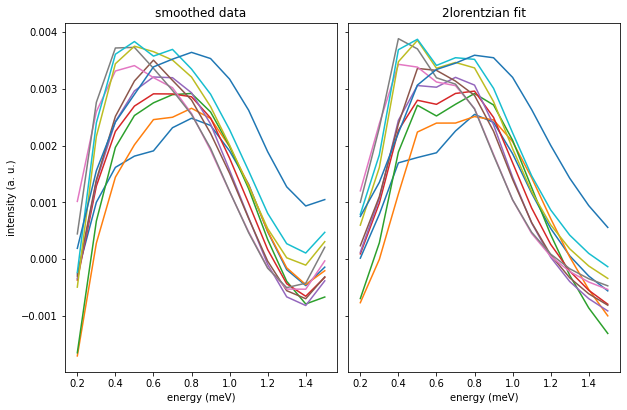

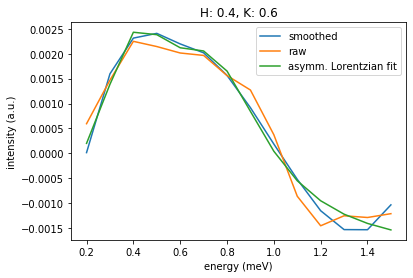

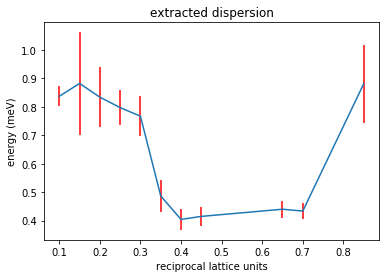

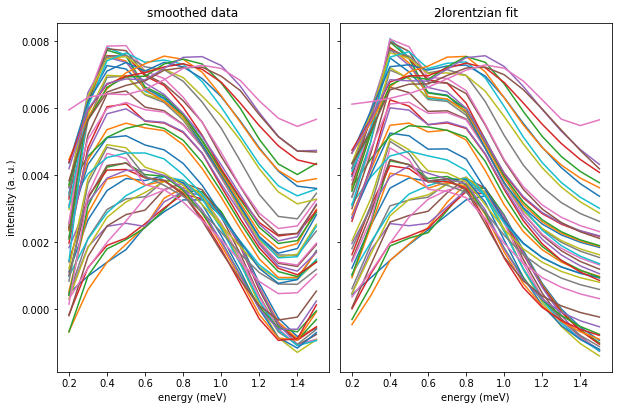

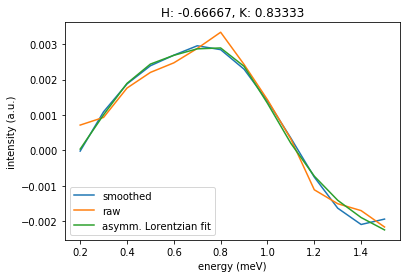

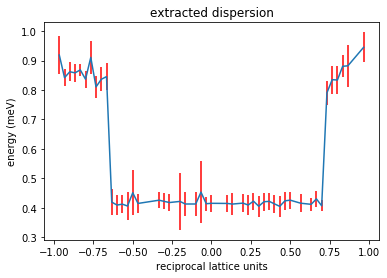

In [44]:
cut_direction = [1,-1,0]
dispersion_arrayGMG,h_or_k = get_dispersion_from_segment(data4TGMG)
dispersion_arrayGKMKG,h_or_k = get_dispersion_from_segment(data4TGKMKG)

#dispersion_array0p5,h_or_k = get_dispersion_from_segment(data0p5,cut_direction)
eMin,eMax,smoothing,order,window,amp1, cen1, wid1, amp2,cen2,wid2,bg = 0.1,1.5,1,3,9,0.0015,0.7,0.2,0.003,0.8,0.2,0.0005

GMG4T_Lorentz,exceptions = get_dispersion_2Lorentz(data4TGMG,eMin,eMax,smoothing,order,window,amp1, cen1, wid1, amp2,cen2,wid2,bg,1,2)
GKMKG4T_Lorentz,exceptions = get_dispersion_2Lorentz(data4TGKMKG,eMin,eMax,smoothing,order,window,amp1, cen1, wid1, amp2,cen2,wid2,bg,1,2)
#save_dispersion_array(np.hstack((GMG0p05_Lorentz,np.fliplr(GKMKG0p05_Lorentz))),'dispersion_0p30p05_Lorentz_max.txt')
#save_dispersion_array(np.hstack((GMG0p05e0p1_Lorentz,np.fliplr(GKMKG0p05e0p1_Lorentz))),'dispersion_0p3,0p05e0p1_Lorentz_max.txt')